# Notebook 3: Targeting Simulations
Includes replication code for:
- Table 2
- Table 3
- Table 4
- Figure 1
- Table S5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, \
    roc_curve
from multiprocessing import Pool

In [2]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

### Create simulation datasets

In [3]:
# Read data
results = pd.read_csv('data/interim_analysis_datasets/merged_predictions.csv')
survey = pd.read_csv('data/interim_analysis_datasets/survey_with_asset_index.csv')

# Matched subsample, unweighted
matched = results.copy()
matched['asset_index'] = -matched['asset_index']
matched['log_expend'] = -matched['log_expend']

# Matched subsample plus non phone owners
unmatched = survey[~survey['hhid'].isin(matched['hhid'])]
unmatched_no_phone = unmatched[unmatched['num_phones'] == 0].copy()
matched_or_no_phone = pd.concat([matched, unmatched_no_phone])
percent_no_phone = survey[survey['num_phones'] == 0]['weight'].sum()/survey['weight'].sum()
print('Percent with no phone: %.2f' % percent_no_phone)
weight_unmatched = percent_no_phone
weight_matched = 1 - percent_no_phone
weight_adj_unmatched = weight_unmatched/matched_or_no_phone[pd.isnull(matched_or_no_phone['cdr'])]['weight'].sum()
weight_adj_matched = weight_matched/matched_or_no_phone[~pd.isnull(matched_or_no_phone['cdr'])]['weight'].sum()
ratio = weight_adj_unmatched/weight_adj_matched
print('To adjust for phone ownership, weight unmatched observations by %.4f' % ratio)
matched_or_no_phone['weight'] = matched_or_no_phone\
    .apply(lambda row: row['weight']*weight_adj_unmatched if pd.isnull(row['cdr']) 
           else row['weight']*weight_adj_matched, axis=1)
matched_or_no_phone['weight'] = matched_or_no_phone['weight']/matched_or_no_phone['weight'].max()*100
matched_or_no_phone = pd.DataFrame(matched_or_no_phone.values.repeat(matched_or_no_phone['weight'], axis=0), 
                                   columns=matched_or_no_phone.columns)
matched_or_no_phone_phoneless_last = matched_or_no_phone.copy()
matched_or_no_phone_phoneless_last['cdr'] = matched_or_no_phone_phoneless_last['cdr'].fillna(0)
matched_or_no_phone_phoneless_last['asset_index+log_expend+cdr'] = \
    matched_or_no_phone_phoneless_last['asset_index+log_expend+cdr'].fillna(0)
matched_or_no_phone_phoneless_first = matched_or_no_phone.copy()
matched_or_no_phone_phoneless_first['cdr'] = matched_or_no_phone_phoneless_first['cdr'].fillna(1)
matched_or_no_phone_phoneless_first['asset_index+log_expend+cdr'] = \
    matched_or_no_phone_phoneless_first['asset_index+log_expend+cdr'].fillna(1)

# All survey observations, with sample weights applied
all_survey_obs = pd.concat([matched, unmatched])
all_survey_obs['weight'] = all_survey_obs['weight']/all_survey_obs['weight'].max()*100
all_survey_obs = pd.DataFrame(all_survey_obs.values.repeat(all_survey_obs['weight'], axis=0), 
                                   columns=all_survey_obs.columns)
all_survey_obs_phoneless_last = all_survey_obs.copy()
all_survey_obs_phoneless_last['cdr'] = all_survey_obs_phoneless_last['cdr'].fillna(0)
all_survey_obs_phoneless_last['asset_index+log_expend+cdr'] = \
    all_survey_obs_phoneless_last['asset_index+log_expend+cdr'].fillna(0)
all_survey_obs_phoneless_first = all_survey_obs.copy()
all_survey_obs_phoneless_first['cdr'] = all_survey_obs_phoneless_first['cdr'].fillna(1)
all_survey_obs_phoneless_first['asset_index+log_expend+cdr'] = \
    all_survey_obs_phoneless_first['asset_index+log_expend+cdr'].fillna(1)

# Adjust weights for matched dataset to 1
matched['weight'] = 1

Percent with no phone: 0.26
To adjust for phone ownership, weight unmatched observations by 0.2698


### Table 2

In [4]:
def get_results_table(groundtruth, results, proxies, adjust=True, round_values=False):
    scores_df = []
    df = results.copy()
    df[groundtruth] = df[groundtruth].astype('float')
    np.random.seed(0)
    df['random'] = np.random.rand(df.shape[0])
    for proxy in proxies:
        df[proxy] = df[proxy].astype('float')
        num_up = df[df[groundtruth] == 1].shape[0]
        cutoff = num_up/df.shape[0]
        df = df.sort_values([proxy, 'random'], ascending=False)
        df['predicted_up'] = np.concatenate([np.ones(num_up), np.zeros(df.shape[0] - num_up)])
        row = [proxy, '%.9f'% roc_auc_score(df[groundtruth], df[proxy]), 
               '%.9f'% accuracy_score(df[groundtruth], df['predicted_up']),
               '%.9f'% precision_score(df[groundtruth], df['predicted_up']),
               '%.9f'% recall_score(df[groundtruth], df['predicted_up'])]
        # Adjust for any randomness errors in random targeting
        if proxy == 'random' and adjust == True:
            row[1] = 0.50
            row[3] = '%.2f' % cutoff
            row[4] = '%.2f' % cutoff
        scores_df.append(row)
    scores_df = pd.DataFrame(scores_df, columns=['Targeting Method', 'AUC', 'Accuracy', 
                                                 'Precision', 'Recall'])
    if round_values:
        for col in ['AUC', 'Accuracy', 'Precision', 'Recall']:
            scores_df[col] = scores_df[col].astype('float').round(2)
    return scores_df

In [5]:
def bootstrap(groundtruth, results, proxies, round_values=False):
    results_deduplicated = results.drop_duplicates(subset=['hhid'])
    # NOTE: For the purpose of this replication code I've used 100 bootstrap samples to make it run more quickly,
    # to replicate the real paper we used 1000 bootstrap samples.
    seeds = range(0, 100)
    bootstrap_results = []
    for seed in seeds:
        bs_sample = results_deduplicated.sample(n=len(results_deduplicated), replace=True, random_state=seed)
        bs_sample = pd.DataFrame(bs_sample.values.repeat(bs_sample['weight'], axis=0), columns=bs_sample.columns)
        bootstrap_results.append(get_results_table(groundtruth, bs_sample, proxies, adjust=False))
    std = np.dstack([bootstrap_results[i].values[:, 1:] for i in range(len(bootstrap_results))])\
        .astype('float').std(axis=2)
    std = pd.DataFrame(std, columns=['AUC', 'Accuracy', 'Precision', 'Recall'])
    if round_values:
        for col in ['AUC', 'Accuracy', 'Precision', 'Recall']:
            std[col] = std[col].astype('float').round(2)
    std['Targeting Method'] = proxies
    return std

In [6]:
def get_results_table_with_bootstrap(groundtruth, results, proxies, adjust=True, round_values=False):
    point_estimates = get_results_table(groundtruth, results, proxies, adjust=adjust, round_values=round_values)
    std = bootstrap(groundtruth, results, proxies, round_values=round_values)
    for col in point_estimates.columns:
        if col != 'Targeting Method':
            point_estimates[col] = point_estimates.apply(lambda row: '%.2f (%.2f)' % 
                (row[col], std[std['Targeting Method'] == row['Targeting Method']][col].values[0]), axis=1)
    return point_estimates

#### Panel A

In [7]:
panela = get_results_table_with_bootstrap('ultra_poor', matched, ['random', 'asset_index', 'log_expend', 'cdr', 
        'asset_index+log_expend+cdr'], adjust=True, round_values=True)
panela['Targeting Method'] = ['Random', 'Asset Index', 'Consumption', 'CDR', 'Combined']
panela.to_csv('results/tables/table2_panela.csv', index=False)
panela

,Targeting Method,AUC,Accuracy,Precision,Recall
0,Random,0.50 (0.03),0.64 (0.02),0.22 (0.04),0.22 (0.04)
1,Asset Index,0.49 (0.03),0.65 (0.03),0.22 (0.03),0.22 (0.03)
2,Consumption,0.49 (0.03),0.65 (0.03),0.22 (0.04),0.22 (0.04)
3,CDR,0.50 (0.03),0.64 (0.03),0.21 (0.04),0.21 (0.04)
4,Combined,0.32 (0.03),0.59 (0.03),0.08 (0.03),0.08 (0.03)


#### Panel B

In [8]:
panelb_phoneless_first = get_results_table_with_bootstrap('ultra_poor', matched_or_no_phone_phoneless_first, 
                        ['random', 'asset_index', 'log_expend', 'cdr', 'asset_index+log_expend+cdr'], 
                        adjust=True, round_values=True)
panelb_phoneless_first['Targeting Method'] = ['Random', 'Asset Index', 'Consumption', 
                                              'CDR (Target Phonless First)', 'Combined (Target Phoneless First)']

In [9]:
panelb_phoneless_last = get_results_table_with_bootstrap('ultra_poor', matched_or_no_phone_phoneless_last, 
                        ['cdr', 'asset_index+log_expend+cdr'], 
                        adjust=True, round_values=True)
panelb_phoneless_last['Targeting Method'] = ['CDR (Target Phonless Last)', 'Combined (Target Phoneless Last)']

In [10]:
panelb = pd.concat([panelb_phoneless_first, panelb_phoneless_last])
panelb.to_csv('results/tables/table2_panelb.csv', index=False)
panelb

,Targeting Method,AUC,Accuracy,Precision,Recall
0,Random,0.50 (0.00),0.57 (0.01),0.68 (0.02),0.68 (0.02)
1,Asset Index,0.49 (0.03),0.56 (0.03),0.68 (0.03),0.68 (0.03)
2,Consumption,0.50 (0.03),0.56 (0.02),0.67 (0.03),0.67 (0.03)
3,CDR (Target Phonless First),0.51 (0.03),0.57 (0.02),0.68 (0.02),0.68 (0.02)
4,Combined (Target Phoneless First),0.40 (0.03),0.48 (0.02),0.62 (0.03),0.62 (0.03)
0,CDR (Target Phonless Last),0.49 (0.02),0.55 (0.02),0.67 (0.03),0.67 (0.03)
1,Combined (Target Phoneless Last),0.39 (0.02),0.52 (0.03),0.64 (0.03),0.64 (0.03)


#### Panel C

In [11]:
panelc_phoneless_first = get_results_table_with_bootstrap('ultra_poor', all_survey_obs_phoneless_first, 
                        ['random', 'asset_index', 'log_expend', 'cdr', 'asset_index+log_expend+cdr'], 
                        adjust=True, round_values=True)
panelc_phoneless_first['Targeting Method'] = ['Random', 'Asset Index', 'Consumption', 
                                              'CDR (Target Phonless First)', 'Combined (Target Phoneless First)']

In [12]:
panelc_phoneless_last = get_results_table_with_bootstrap('ultra_poor', all_survey_obs_phoneless_first, 
                        ['cdr', 'asset_index+log_expend+cdr'], 
                        adjust=True, round_values=True)
panelc_phoneless_last['Targeting Method'] = ['CDR (Target Phonless Last)', 'Combined (Target Phoneless Last)']

In [13]:
panelc = pd.concat([panelc_phoneless_first, panelc_phoneless_last])
panelc.to_csv('results/tables/table2_panelc.csv', index=False)
panelc

,Targeting Method,AUC,Accuracy,Precision,Recall
0,Random,0.50 (0.00),0.55 (0.01),0.66 (0.01),0.66 (0.01)
1,Asset Index,0.50 (0.01),0.55 (0.01),0.66 (0.01),0.66 (0.01)
2,Consumption,0.49 (0.02),0.54 (0.01),0.65 (0.01),0.65 (0.01)
3,CDR (Target Phonless First),0.49 (0.01),0.54 (0.01),0.65 (0.01),0.65 (0.01)
4,Combined (Target Phoneless First),0.49 (0.01),0.54 (0.01),0.65 (0.01),0.65 (0.01)
0,CDR (Target Phonless Last),0.49 (0.01),0.54 (0.01),0.65 (0.01),0.65 (0.01)
1,Combined (Target Phoneless Last),0.49 (0.01),0.54 (0.01),0.65 (0.01),0.65 (0.01)


### Table S5

In [14]:
tables5 = get_results_table_with_bootstrap('ultra_poor', matched, ['asset_index', 'log_expend', 'cdr', 
        'asset_index+log_expend', 'asset_index+cdr', 'log_expend+cdr', 'asset_index+log_expend+cdr'], 
        adjust=True, round_values=True)
tables5['Targeting Method'] = ['Asset Index', 'Consumption', 'CDR', 'Assets + Consumption', 'Assets + CDR', 
                             'Consumption + CDR', 'Assets + Consumption + CDR']
tables5 = tables5[['Targeting Method', 'AUC']]
tables5.to_csv('results/tables/tables5.csv', index=False)
tables5

,Targeting Method,AUC
0,Asset Index,0.49 (0.03)
1,Consumption,0.49 (0.03)
2,CDR,0.50 (0.03)
3,Assets + Consumption,0.34 (0.03)
4,Assets + CDR,0.36 (0.03)
5,Consumption + CDR,0.36 (0.03)
6,Assets + Consumption + CDR,0.32 (0.03)


### Figure 1

#### Panel A

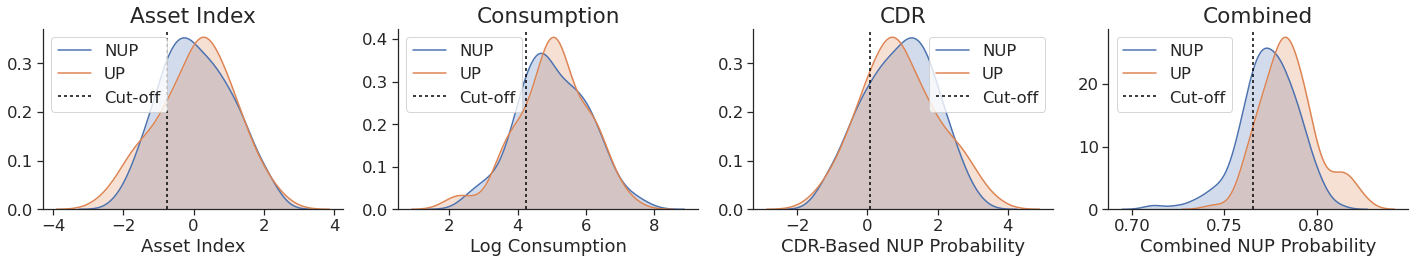

In [15]:
# Get data
results = matched.copy()
num_up = len(results[results['ultra_poor'] == 1])
targeting_vector = np.concatenate([np.ones(num_up), np.zeros(len(results) - num_up)])

# Adjust data so that all values are negatively correlated with being UP
results['asset_index'] = -results['asset_index']
results['log_expend'] = -results['log_expend']
results['cdr'] = 1-results['asset_index']
results['asset_index+log_expend+cdr'] = 1-results['asset_index+log_expend+cdr']

# Set up figure
proxies = ['asset_index', 'log_expend', 'cdr', 'asset_index+log_expend+cdr']
titles = ['Asset Index', 'Consumption', 'CDR', 'Combined']
xlabels = ['Asset Index', 'Log Consumption', 'CDR-Based NUP Probability', 'Combined NUP Probability']
sns.set(font_scale=1.5, style='white')
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for p, proxy in enumerate(proxies):
    
    # Calculate the cut-off and assign predicted UP/NUP
    results = results.sort_values(proxy, ascending=True)
    results[proxy + '_predicted_up'] = targeting_vector
    cutoff = results[results[proxy + '_predicted_up'] == 1][proxy].max()
    
    # Kernel density estimates
    sns.kdeplot(results[results['ultra_poor'] == 0][proxy], ax=ax[p], label='NUP', shade=True)
    sns.kdeplot(results[results['ultra_poor'] == 1][proxy], ax=ax[p], label='UP', shade=True)
    ax[p].axvline(cutoff, color='black', dashes=[2, 2], label='Cut-off')
    ax[p].legend(loc='best')
    ax[p].set_title(titles[p], fontsize='large')
    ax[p].set_xlabel(xlabels[p])
    simpleaxis(ax[p])

# Clean up plot
plt.tight_layout()
plt.savefig('results/figures/figure1_panela.png', dpi=500)
plt.show()

#### Panel B

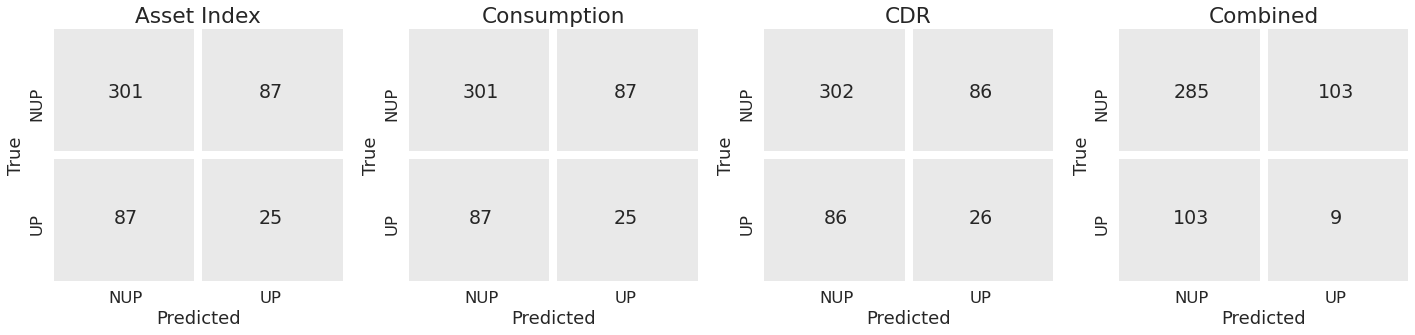

In [16]:
# Set up plot
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for p, proxy in enumerate(proxies): 
    cm = confusion_matrix(results['ultra_poor'], results[proxy + '_predicted_up'])
    sns.heatmap(cm, ax=ax[p], cbar=False, vmin=-1000000000, vmax=5000000000, annot=True, fmt='g', 
                xticklabels=['NUP', 'UP'], yticklabels=['NUP', 'UP'], cmap='Greys', annot_kws={"fontsize":19})
    ax[p].set_xlabel('Predicted')
    ax[p].set_ylabel('True')
    ax[p].hlines([1], *ax[p].get_xlim(), color='white', linewidth=8)
    ax[p].vlines([1], *ax[p].get_ylim(), color='white', linewidth=8)
    ax[p].set_title(titles[p], fontsize='large')

# Clean up plot
plt.tight_layout()
plt.savefig('results/figures/figure1_panelb.png', dpi=500)
plt.show()

#### Panel C

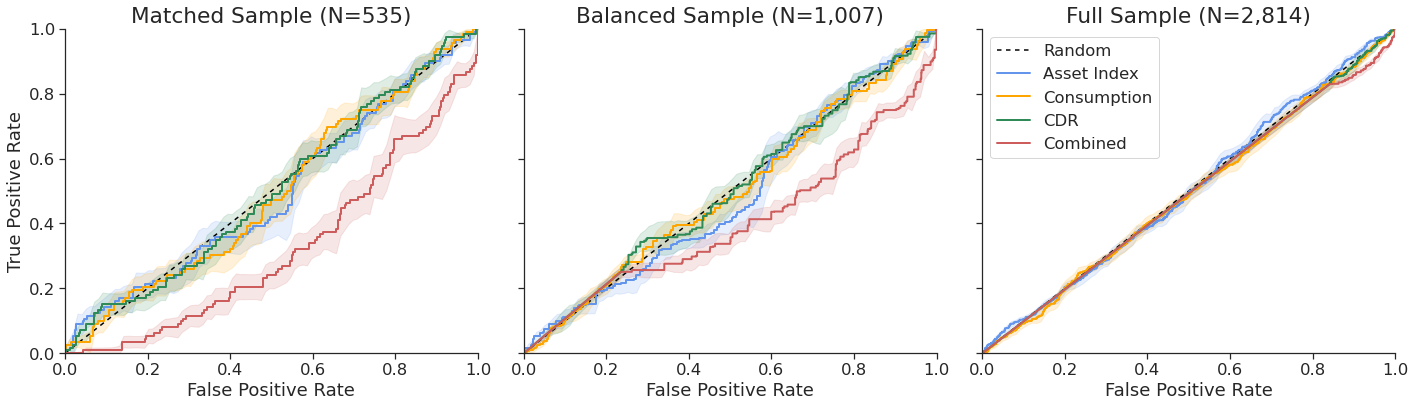

In [17]:
# Set up plot
sns.set(font_scale=1.5, style='white')
titles = ['Matched Sample (N=535)', 'Balanced Sample (N=1,007)', 'Full Sample (N=2,814)']
colors = ['cornflowerblue', 'orange', 'seagreen', 'indianred']
labels = ['Asset Index', 'Consumption', 'CDR', 'Combined']
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
ax = ax.flatten()

for a, df, proxies in [
    (0, matched, ['asset_index', 'log_expend', 'cdr', 'asset_index+log_expend+cdr']),
    (1, matched_or_no_phone_phoneless_first, ['asset_index', 'log_expend', 'cdr', 'asset_index+log_expend+cdr']),
    (2, all_survey_obs_phoneless_first, ['asset_index', 'log_expend', 'cdr', 'asset_index+log_expend+cdr'])]:
    df = df[['ultra_poor', 'weight', 'hhid'] + proxies].copy()
    for col in df.columns:
        if col != 'hhid':
            df[col] = df[col].astype('float')
            
    for p, proxy in enumerate(proxies):
        
        # Dashed x=y line for random targeting
        if p == 0:
            ax[a].plot([0, 1], [0, 1], color='black', dashes=[3, 3], label='Random')
            
        # Get ROC curve for pooled results
        fpr, tpr, thresh = roc_curve(df['ultra_poor'], df[proxy])
        auc = roc_auc_score(df['ultra_poor'], df[proxy])
        ax[a].plot(fpr, tpr, linewidth=2, color=colors[p], label=labels[p])
        
        # Bootstrap 100 samples to form confidence interval
        mean_fpr = np.linspace(0, 1, 100)
        df_deduplicated = df.drop_duplicates(subset=['hhid'])
        def draw_bootstrap(sample_df):
            sample_df = pd.DataFrame(sample_df.values.repeat(sample_df['weight'], axis=0), 
                                     columns=sample_df.columns)
            fpr_sample, tpr_sample, _ = roc_curve(sample_df['ultra_poor'].astype('float'), 
                                                  sample_df[proxy].astype('float'))
            tpr_sample = np.interp(mean_fpr, fpr_sample, tpr_sample)
            tpr_sample[0] = 0.0
            return tpr_sample
        
        pool = Pool(56)
        # NOTE: For the purpose of this replication code I've used 100 bootstrap samples to make it run more 
        # quickly, to replicate the real paper we used 1000 boostrap samples.
        sample_dfs = [df.sample(len(df_deduplicated), replace=True) for i in range(100)]
        tprs = pool.map(draw_bootstrap, sample_dfs)
        pool.close()
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(np.interp(mean_fpr, fpr, tpr) + std_tpr, 1)
        tprs_lower = np.maximum(np.interp(mean_fpr, fpr, tpr) - std_tpr, 0)
        ax[a].fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[p], alpha=.15)

    # Clean up subplot
    ax[a].set_xlim(0, 1)
    ax[a].set_ylim(0, 1)
    ax[a].set_title(titles[a], fontsize='large')
    simpleaxis(ax[a])

# Clean up plot
ax[2].legend(loc='best')
ax[0].set_xlabel('False Positive Rate')
ax[1].set_xlabel('False Positive Rate')
ax[2].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
plt.tight_layout()
plt.savefig('results/figures/figure1_panelc.png', dpi=500)
plt.show()

### Table 3

In [18]:
# Merge in survey covariates
df = results.merge(survey.drop([c for c in results.columns if c in survey.columns and  c != 'hhid'], 
                               axis=1), on='hhid', how='inner')

# Set up tables
up_mistakes_df = [[''] + ['True Pos.', 'False Neg.', 'Dif.']*3]
nup_mistakes_df = [[''] + ['True Neg.', 'False Pos.', 'Dif.']*3]
covariates = ['asset_index', 'log_expend', 'num_phones', 'fsec_index', 'fin_index', 'psych_index','cwr_group']
covariate_names = ['Asset Index', 'Log Expenditures', '# Phones', 'Food Security Index', 
                   'Financial Inclusion Index', 'Psychological Wellbeing Index', 'CWR Group']

for covariate in covariates:
    up_row = [covariate]
    nup_row = [covariate]
    for proxy in ['asset_index', 'log_expend', 'cdr']:
        
        # Categorize observations into TP, FN, TN, and FP
        tp = df[(df[proxy + '_predicted_up'] == 1) & (df['ultra_poor'] == 1)]
        fn = df[(df[proxy + '_predicted_up'] == 0) & (df['ultra_poor'] == 1)]
        tn = df[(df[proxy + '_predicted_up'] == 0) & (df['ultra_poor'] == 0)]
        fp = df[(df[proxy + '_predicted_up'] == 1) & (df['ultra_poor'] == 0)]
        
        # Get mean of covariates for TP and FN, and do T-test to compare the difference in means
        up_row.append('%.2f (%.2f)' % (np.mean(tp[covariate]), np.std(tp[covariate])))
        up_row.append('%.2f (%.2f)' % (np.mean(fn[covariate]), np.std(fn[covariate])))
        up_row.append('%.2f (%.2f)' % (np.mean(tp[covariate]) - np.mean(fn[covariate]), 
                                       np.sqrt(np.var(tp[covariate])/len(tp) + np.var(fn[covariate])/len(fn))))
        
        # Get mean of covariates for TN and FP, and do T-test to compare the difference in means
        nup_row.append('%.2f (%.2f)' % (np.mean(tn[covariate]), np.std(tn[covariate])))
        nup_row.append('%.2f (%.2f)' % (np.mean(fp[covariate]), np.std(fp[covariate])))
        nup_row.append('%.2f (%.2f)' % (np.mean(tn[covariate]) - np.mean(fp[covariate]), 
                                       np.sqrt(np.var(tn[covariate])/len(tn) + np.var(fp[covariate])/len(fp))))
    up_mistakes_df.append(up_row)
    nup_mistakes_df.append(nup_row)

up_mistakes_df = pd.DataFrame(up_mistakes_df)
nup_mistakes_df = pd.DataFrame(nup_mistakes_df)
up_mistakes_df[0] = [''] + covariate_names 
nup_mistakes_df[0] = [''] + covariate_names

up_mistakes_df.to_csv('results/tables/table3_panela.csv', index=False)
nup_mistakes_df.to_csv('results/tables/table3_panelb.csv', index=False)
up_mistakes_df

,0,1,2,3,4,5,6,7,8,9
0,,True Pos.,False Neg.,Dif.,True Pos.,False Neg.,Dif.,True Pos.,False Neg.,Dif.
1,Asset Index,-1.47 (0.48),0.52 (0.75),-1.99 (0.13),-0.05 (0.98),0.11 (1.11),-0.16 (0.23),1.45 (0.43),-0.34 (0.85),1.79 (0.13)
2,Log Expenditures,5.22 (0.94),4.96 (1.05),0.26 (0.22),3.57 (0.60),5.44 (0.71),-1.87 (0.14),5.21 (0.79),4.96 (1.09),0.25 (0.19)
3,# Phones,1.68 (1.22),1.59 (1.18),0.09 (0.28),2.04 (1.04),1.48 (1.20),0.56 (0.24),1.50 (1.18),1.64 (1.19),-0.14 (0.27)
4,Food Security Index,-0.14 (1.05),-0.21 (0.91),0.07 (0.23),-0.25 (0.87),-0.18 (0.96),-0.07 (0.20),-0.23 (0.91),-0.18 (0.95),-0.04 (0.21)
5,Financial Inclusion Index,0.46 (1.14),0.21 (1.03),0.25 (0.25),0.29 (0.94),0.26 (1.09),0.03 (0.22),0.35 (0.82),0.24 (1.12),0.10 (0.20)
6,Psychological Wellbeing Index,-0.15 (0.88),0.14 (0.90),-0.30 (0.20),0.16 (0.96),0.05 (0.89),0.11 (0.21),0.21 (0.83),0.04 (0.92),0.17 (0.19)
7,CWR Group,3.04 (1.46),3.26 (1.33),-0.22 (0.32),3.08 (1.32),3.25 (1.37),-0.17 (0.30),3.35 (1.24),3.17 (1.39),0.17 (0.29)


### Table 4

In [19]:
# Set up table
proxies = ['asset_index', 'log_expend', 'cdr', 'asset_index+log_expend+cdr']
proxy_names = ['Asset Index', 'Consumption', 'CDR', 'Combined']
overlap_up, overlap_nup = [], []

for p, proxy1 in enumerate(proxies):
    
    # Initialize row
    row_up, row_nup = [], []
    row_up.append(proxy_names[p])
    row_nup.append(proxy_names[p])
    
    for proxy2 in proxies:
        
        # Get FN overlap
        same_fn = results[(results[proxy1 + '_predicted_up'] == 0) & (results[proxy2 + '_predicted_up'] == 0)
                         & (results['ultra_poor'] == 1)].shape[0]
        total_fn = results[(results[proxy1 + '_predicted_up'] == 0) & (results['ultra_poor'] == 1)].shape[0]
        
        # Get FP overlap
        same_fp = results[(results[proxy1 + '_predicted_up'] == 1) & (results[proxy2 + '_predicted_up'] == 1)
                         & (results['ultra_poor'] == 0)].shape[0]
        total_fp = results[(results[proxy1 + '_predicted_up'] == 1) & (results['ultra_poor'] == 0)].shape[0]
        row_up.append(('%.2f' % (100*same_fn/total_fn)) + '%')
        row_nup.append(('%.2f' % (100*same_fp/total_fp)) + '%')
    
    # Add to row
    overlap_up.append(row_up)
    overlap_nup.append(row_nup)
    
# Clean up tables
overlap_up = pd.DataFrame(overlap_up, columns=[''] + proxy_names)
overlap_nup = pd.DataFrame(overlap_nup, columns=[''] + proxy_names)
overlap_up.to_csv('results/tables/table4_panela.csv', index=False)
overlap_nup.to_csv('results/tables/table4_panelb.csv', index=False)
overlap_up

,,Asset Index,Consumption,CDR,Combined
0,Asset Index,100.00%,77.01%,70.11%,90.80%
1,Consumption,77.01%,100.00%,73.56%,95.40%
2,CDR,70.93%,74.42%,100.00%,91.86%
3,Combined,76.70%,80.58%,76.70%,100.00%
